In [1]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=c42EU5MshTGEX7tcXrkob9ryl9Tusi&access_type=offline&code_challenge=fwUno4ym4tS-N1MVyew4SsGRqmeRsWTTvzc7PHjQLzQ&code_challenge_method=S256


Credentials saved to file: [/Users/yt4/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "open-targets-genetics-dev" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [ ]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=UiDTZiS2COSkwLlSyy0l1pVKoF8Yfg&access_type=offline&code_challenge=4jMAWGLzSEe-ozTnSiVWYKCSv6hg9PyZzX727eiHbYk&code_challenge_method=S256


You are now logged in as [yt4@sanger.ac.uk].
Your current project is [open-targets-genetics-dev].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update



In [1]:
import os

import hail as hl
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql import DataFrame

from gentropy.common.session import Session
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.dataset.study_locus import StudyLocus
from gentropy.susie_finemapper import SusieFineMapperStep
from gentropy.method.drug_enrichment_from_evid import chemblDrugEnrichment

"""Common utilities for the project."""

import os
from pathlib import Path
from gentropy.common.session import Session
import logging


def get_gcs_credentials() -> str:
    """Get the credentials for google cloud storage."""
    app_default_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/application_default_credentials.json"
    )

    service_account_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/service_account_credentials.json"
    )

    if Path(app_default_credentials).exists():
        return app_default_credentials
    else:
        raise FileNotFoundError("No GCS credentials found.")


def get_gcs_hadoop_connector_jar() -> str:
    """Get the google cloud storage hadoop connector for spark.

    This function will return the url to download the hadoop jar.
    """

    return (
        "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar"
    )


def gcs_conf(
    credentials_path=None, project="open-targets-genetics-dev"
) -> dict[str, str]:
    """Get the spark configuration with hadoop connector for google cloud storage."""
    credentials_path = credentials_path or get_gcs_credentials()
    return {
        "spark.driver.memory": "12g",
        "spark.kryoserializer.buffer.max": "500m",
        "spark.driver.maxResultSize":"2g",
        "spark.hadoop.fs.gs.impl": "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem",
        "spark.jars": get_gcs_hadoop_connector_jar(),
        "spark.hadoop.google.cloud.auth.service.account.enable": "true",
        "spark.hadoop.fs.gs.project.id": project,
        "spark.hadoop.google.cloud.auth.service.account.json.keyfile": credentials_path,
        "spark.hadoop.fs.gs.requester.pays.mode": "AUTO",
    }


class GentropySession(Session):
    def __init__(self, *args, **kwargs):
        if "extended_spark_conf" in kwargs:
            kwargs["extended_spark_conf"].update(gcs_conf())
        else:
            kwargs["extended_spark_conf"] = gcs_conf()
        super().__init__(*args, **kwargs)

    @property
    def conf(self):
        logging.warning(
            "To change the config restart the session and use the `extended_spark_conf` parameter."
        )
        return self.spark.sparkContext.getConf().getAll()

session= GentropySession()

Loading BokehJS ...

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 13:27:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path_to_release_folder="gs://open-targets-data-releases/25.06/"

si=StudyIndex.from_parquet(session,path_to_release_folder+"output/study/")
sl=StudyLocus.from_parquet(session,path_to_release_folder+"output/credible_set/")

# Removing noise

In [9]:
df=sl.df.filter(f.col("studyType")=="gwas").cache()
df.count()

25/07/03 11:41:53 WARN CacheManager: Asked to cache already cached data.


789453

In [10]:
df.printSchema()

root
 |-- studyLocusId: string (nullable = true)
 |-- studyType: string (nullable = true)
 |-- variantId: string (nullable = true)
 |-- chromosome: string (nullable = true)
 |-- position: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- studyId: string (nullable = true)
 |-- beta: double (nullable = true)
 |-- zScore: double (nullable = true)
 |-- pValueMantissa: float (nullable = true)
 |-- pValueExponent: integer (nullable = true)
 |-- effectAlleleFrequencyFromSource: float (nullable = true)
 |-- standardError: double (nullable = true)
 |-- subStudyDescription: string (nullable = true)
 |-- qualityControls: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- finemappingMethod: string (nullable = true)
 |-- credibleSetIndex: integer (nullable = true)
 |-- credibleSetlog10BF: double (nullable = true)
 |-- purityMeanR2: double (nullable = true)
 |-- purityMinR2: double (nullable = true)
 |-- locusStart: integer (nullable = true)
 |-- locusEnd

In [22]:
df.show(1)

+--------------------+---------+---------------+----------+--------+------+------------+-------+------+--------------+--------------+-------------------------------+-------------+-------------------+--------------------+-----------------+----------------+------------------+------------+-----------+----------+--------+----------+--------------------+--------------------+--------------------+----------+----------+
|        studyLocusId|studyType|      variantId|chromosome|position|region|     studyId|   beta|zScore|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|subStudyDescription|     qualityControls|finemappingMethod|credibleSetIndex|credibleSetlog10BF|purityMeanR2|purityMinR2|locusStart|locusEnd|sampleSize|               ldSet|               locus|          confidence|isTransQtl|locus_size|
+--------------------+---------+---------------+----------+--------+------+------------+-------+------+--------------+--------------+-------------------------------+---

In [11]:
repl_cs=session.spark.read.parquet("gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/list_of_gwas_replicated_CSs.parquet")

In [12]:
df = df.withColumn("locus_size", f.size(f.col("locus"))).cache()
df.count()

789453

In [13]:
df.join(repl_cs,on="studyLocusId",how="inner").count()

263705

In [15]:
df_f=df.filter(f.col("finemappingMethod")=="SuSie")
print("orig size:", df_f.count())
print("repl_size:", df_f.join(repl_cs,on="studyLocusId",how="inner").count())

orig size: 20704


repl_size: 1882


In [17]:
df_f=df.filter(f.col("finemappingMethod")=="SuSiE-inf")
print("orig size:", df_f.count())
print("repl_size:", df_f.join(repl_cs,on="studyLocusId",how="inner").count())

orig size: 468986


repl_size: 163693


In [19]:
df_f=df.filter(f.col("finemappingMethod")=="PICS")
print("orig size:", df_f.count())
print("repl_size:", df_f.join(repl_cs,on="studyLocusId",how="inner").count())

orig size: 299763


repl_size: 98130


In [62]:
df_f=df.filter(f.col("finemappingMethod")=="SuSiE-inf")

In [68]:
df_f1=df_f.filter((f.col("locus_size")==1) & (f.col("pValueExponent")>-7))
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(repl_cs,on="studyLocusId",how="inner").count())

orig size: 10862


repl_size: 1521


In [69]:
1521/10862

0.14002946050451115

In [70]:
df_f1=df_f.filter((f.col("locus_size")==1) & (f.col("pValueExponent")>-7))
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(semi_repl_varinatId,on="variantId",how="inner").count())

orig size: 10862


repl_size: 7647


In [71]:
7647/10862

0.7040139937396428

In [33]:
df_beta=session.spark.read.parquet("gs://genetics-portal-dev-analysis/ss60/gentropy-manuscript/chapters/variant-effect-prediction/25.07/lead_variant_effect").drop("leadVariantConsequence")

In [35]:
df_beta.show(1)

+--------------+--------------------+--------------------+----------+------+------------+---------------------+--------------------+-----------------+----------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+
|     variantId|             variant|        studyLocusId|   studyId|geneId|originalBeta|originalStandardError|     locusStatistics|finemappingMethod|isTransQtl|       variantEffect|majorLdPopulation|majorLdPopulationMaf| majorLdPopulationAf|   variantStatistics|     studyStatistics|  rescaledStatistics|traitFromSourceMappedIds|
+--------------+--------------------+--------------------+----------+------+------------+---------------------+--------------------+-----------------+----------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+
|4_8801

In [38]:
df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="nfe")
df_beta_pop.count()

2740023

In [39]:
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(repl_cs,on="studyLocusId",how="inner").count())

orig size: 428580


repl_size: 151185


In [72]:
df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="eas")
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(repl_cs,on="studyLocusId",how="inner").count())

df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="eas")
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(semi_repl_varinatId,on="variantId",how="inner").count())

orig size: 26367


repl_size: 8721


orig size: 26367


repl_size: 19309


In [73]:
df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="nfe")
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(repl_cs,on="studyLocusId",how="inner").count())

df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="nfe")
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(semi_repl_varinatId,on="variantId",how="inner").count())

orig size: 428580


repl_size: 151185


orig size: 428580


repl_size: 340809


In [76]:
df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="afr")
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(repl_cs,on="studyLocusId",how="inner").count())

df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="afr")
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(semi_repl_varinatId,on="variantId",how="inner").count())

orig size: 14039


repl_size: 3787


orig size: 14039


repl_size: 9721


In [78]:
19309/26367

0.7323169112906285

In [45]:
sl.df.select("variantId").distinct().count()

996160

In [ ]:
ll=sl.df.groupBy("variantId").count()
semi_repl_varinatId=ll.filter(f.col("count")>1).select("variantId").distinct()

996160

In [48]:
ll.filter(f.col("count")>1).count()

377190

In [51]:
df_f1=df_f.join(semi_repl_varinatId,on="variantId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(repl_cs,on="studyLocusId",how="inner").count())

orig size: 369839


repl_size: 163693


In [53]:
df_f.count()

468986

In [ ]:
df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="afr")
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(repl_cs,on="studyLocusId",how="inner").count())

orig size: 14039


repl_size: 3787


In [55]:
df_beta_pop=df_beta.filter(f.col("majorLdPopulation.ldPopulation")=="afr").join(semi_repl_varinatId,on="variantId",how="inner")
df_f1=df_f.join(df_beta_pop,on="studyLocusId",how="inner")
print("orig size:", df_f1.count())
print("repl_size:", df_f1.join(repl_cs,on="studyLocusId",how="inner").count())

orig size: 9721


repl_size: 3787


In [56]:
df_beta.count()

2833758

In [57]:
df_beta.filter(f.col("majorLdPopulationMaf.value")<=0.01).count()

188153

In [58]:
188153/2833758

0.06639698943946519

In [59]:
df_beta.join(semi_repl_varinatId,on="variantId",how="inner").filter(f.col("majorLdPopulationMaf.value")<=0.01).count()

74780

In [60]:
df_beta.join(semi_repl_varinatId,on="variantId",how="inner").count()

2214788

In [61]:
74780/2214788

0.033763953931482384

# Rare vs common and big and small beta CHEMBL enrichement

In [3]:
df=session.spark.read.parquet("gs://genetics-portal-dev-analysis/ss60/gentropy-manuscript/chapters/variant-effect-prediction/25.07/lead_variant_effect").cache()

In [4]:
df.printSchema()

root
 |-- variantId: string (nullable = true)
 |-- variant: struct (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: integer (nullable = true)
 |    |-- end: integer (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- ref: string (nullable = true)
 |    |-- alt: string (nullable = true)
 |    |-- length: integer (nullable = true)
 |-- studyLocusId: string (nullable = true)
 |-- studyId: string (nullable = true)
 |-- geneId: string (nullable = true)
 |-- originalBeta: double (nullable = true)
 |-- originalStandardError: double (nullable = true)
 |-- locusStatistics: struct (nullable = true)
 |    |-- locusSize: integer (nullable = true)
 |    |-- locusLength: integer (nullable = true)
 |    |-- locusStart: integer (nullable = true)
 |    |-- locusEnd: integer (nullable = true)
 |    |-- leadVariantPIP: double (nullable = true)
 |-- finemappingMethod: string (nullable = true)
 |-- isTransQtl: boolean (nullable = true)
 |-- variantEffect: a

In [5]:
df=df.join(sl.df.select("studyLocusId","studyType"), on="studyLocusId", how="inner").drop("leadVariantConsequence")
df=df.join(si.df.select("pubmedId","studyId"), on="studyId", how="inner")

In [6]:
df=df.filter(f.col("studyType")=="gwas").cache()
df.count()

789453

In [7]:
df.printSchema()

root
 |-- studyId: string (nullable = true)
 |-- studyLocusId: string (nullable = true)
 |-- variantId: string (nullable = true)
 |-- variant: struct (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: integer (nullable = true)
 |    |-- end: integer (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- ref: string (nullable = true)
 |    |-- alt: string (nullable = true)
 |    |-- length: integer (nullable = true)
 |-- geneId: string (nullable = true)
 |-- originalBeta: double (nullable = true)
 |-- originalStandardError: double (nullable = true)
 |-- locusStatistics: struct (nullable = true)
 |    |-- locusSize: integer (nullable = true)
 |    |-- locusLength: integer (nullable = true)
 |    |-- locusStart: integer (nullable = true)
 |    |-- locusEnd: integer (nullable = true)
 |    |-- leadVariantPIP: double (nullable = true)
 |-- finemappingMethod: string (nullable = true)
 |-- isTransQtl: boolean (nullable = true)
 |-- variantEffect: a

In [8]:
df.show(1)

+------------+--------------------+---------------+--------------------+------+--------------------+---------------------+--------------------+-----------------+----------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+---------+--------+
|     studyId|        studyLocusId|      variantId|             variant|geneId|        originalBeta|originalStandardError|     locusStatistics|finemappingMethod|isTransQtl|       variantEffect|majorLdPopulation|majorLdPopulationMaf| majorLdPopulationAf|   variantStatistics|     studyStatistics|  rescaledStatistics|traitFromSourceMappedIds|studyType|pubmedId|
+------------+--------------------+---------------+--------------------+------+--------------------+---------------------+--------------------+-----------------+----------+--------------------+-----------------+--------------------+--------------------+--------------------+----

In [9]:
ll=sl.df.groupBy("variantId").count()
semi_repl_variantId=ll.filter(f.col("count")>1).select("variantId").distinct()

In [10]:
q_cs=session.spark.read.parquet("gs://genetics-portal-dev-analysis/dc16/output/gentropy_paper/qualifying_credible_sets")

In [11]:
df=df.join(q_cs.select("studyLocusId"), on="studyLocusId", how="inner").cache()
df.count()

72444

In [12]:
df=df.join(semi_repl_variantId.select("variantId"), on="variantId", how="inner").cache()
df.count()

53257

In [13]:
df_filtered=df

In [55]:
repl_cs=session.spark.read.parquet("gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/list_of_gwas_replicated_CSs.parquet")

In [56]:
df=df.join(repl_cs, on="studyLocusId", how="inner").cache()
df.count()

263705

In [87]:
df=df.filter(f.col("majorLdPopulation.ldPopulation")!="afr").cache()
df.count()

71529

In [ ]:
df1=df.filter(f.col("pubmedId")==39024449)
df1.select("studyLocusId")

12654

In [122]:
df=df.join(df1.select("studyLocusId"), on="studyLocusId", how="left_anti").cache()
df.count()

59790

In [123]:
59790+12654

72444

In [175]:
df_filtered=(df.filter(f.col("studyType")=="gwas")
             .filter(
(f.col("majorLdPopulationMaf.value").isNotNull())&
(f.col("majorLdPopulationMaf.value")>0)&
(f.col("studyStatistics.nCases")<f.col("studyStatistics.nControls"))&
(f.col("rescaledStatistics.estimatedBeta")<=3) &
(f.col("rescaledStatistics.estimatedBeta")>=-3)&
(f.col("rescaledStatistics.prevalence").isNotNull())&
(~f.isnan(f.col("rescaledStatistics.prevalence")))&
(f.col("rescaledStatistics.prevalence")>=0.001)&
(f.col("studyStatistics.nSamples")>=100000)
).cache())
df_filtered.count()

75224

In [172]:
to_exclude=si.df.filter(f.col("pubmedId").isin([40164604,40229599,40069456])).select("studyId")
to_exclude.count()

80

In [173]:
studyLocusId_to_exclude=sl.df.join(to_exclude,on="studyId",how="inner").select("studyLocusId").distinct().cache()
studyLocusId_to_exclude.count()

10735

In [174]:
df=df.join(studyLocusId_to_exclude, on="studyLocusId", how="left_anti").cache()
df.count()

778718

In [149]:
df_filtered=(df.filter(f.col("studyType")=="gwas")
             .filter(
(f.col("majorLdPopulationMaf.value").isNotNull())&
(f.col("majorLdPopulationMaf.value")>0)&
(f.col("rescaledStatistics.estimatedBeta")<=30) &
(f.col("rescaledStatistics.estimatedBeta")>=-30)
).cache())
df_filtered.count()

72444

In [150]:
df_filtered.show(1)

+--------------------+------------+-------------+--------------------+------+------------------+---------------------+--------------------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+---------+--------+
|        studyLocusId|     studyId|    variantId|             variant|geneId|      originalBeta|originalStandardError|     locusStatistics|finemappingMethod|isTransQtl|       variantEffect|   majorLdPopulation|majorLdPopulationMaf| majorLdPopulationAf|   variantStatistics|     studyStatistics|  rescaledStatistics|traitFromSourceMappedIds|studyType|pubmedId|
+--------------------+------------+-------------+--------------------+------+------------------+---------------------+--------------------+-----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------

In [14]:
disease_index_path=path_to_release_folder+"output/disease/disease.parquet"
disease_index_orig = session.spark.read.parquet(disease_index_path)

platform_chembl_evidence_path=path_to_release_folder+"output/evidence/sourceId=chembl"
chembl_evidence=session.spark.read.parquet(platform_chembl_evidence_path)

In [15]:
# combinig it with l2g predictions
#l2g=session.spark.read.parquet(path_to_release_folder+"output/l2g_prediction")

In [16]:
# combinig it with l2g predictions
#l2g=session.spark.read.parquet("gs://ot-team/irene/l2g/xgboost/2706/l2g_predictions").select("studyLocusId","geneId","score")

In [17]:
l2g=session.spark.read.parquet("gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/list_of_prioritised_genes_per_CS.parquet").select("studyLocusId","geneId","score")

In [18]:
import pandas as pd
all_enrich = []

In [19]:
# Rare
studyLoci_to_select=df_filtered.filter(f.col("majorLdPopulationMaf.value")<0.01).select("studyLocusId").distinct()
evidence_l2g = l2g.join(studyLoci_to_select, on="studyLocusId", how="inner")
evidence_l2g.count()

1953

In [20]:
coln="Rare"
evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=evidence_l2g,
    score_column="score",
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.1
)
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.1,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = coln
all_enrich.append(enrich)

In [21]:
# Common
studyLoci_to_select=df_filtered.filter(f.col("majorLdPopulationMaf.value")>=0.01).select("studyLocusId").distinct()
evidence_l2g = l2g.join(studyLoci_to_select, on="studyLocusId", how="inner")
evidence_l2g.count()

51479

In [22]:
coln="Common"
evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=evidence_l2g,
    score_column="score",
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.1
)
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.1,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = coln
all_enrich.append(enrich)

In [23]:
# Big effect
studyLoci_to_select=df_filtered.filter((f.col("rescaledStatistics.estimatedBeta")>0.5)|(f.col("rescaledStatistics.estimatedBeta")<-0.5)).select("studyLocusId").distinct()
evidence_l2g = l2g.join(studyLoci_to_select, on="studyLocusId", how="inner")
evidence_l2g.count()

3018

In [24]:
coln="Big effect"
evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=evidence_l2g,
    score_column="score",
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.1
)
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.1,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = coln
all_enrich.append(enrich)

In [25]:
# Small effect
studyLoci_to_select=df_filtered.filter((f.col("rescaledStatistics.estimatedBeta")<=0.5)&(f.col("rescaledStatistics.estimatedBeta")>=-0.5)).select("studyLocusId").distinct()
evidence_l2g = l2g.join(studyLoci_to_select, on="studyLocusId", how="inner")
evidence_l2g.count()

50414

In [26]:
coln="Small effect"
evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=evidence_l2g,
    score_column="score",
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.1
)
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.1,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = coln
all_enrich.append(enrich)


In [27]:
combined_enrich = pd.concat(all_enrich, ignore_index=True)

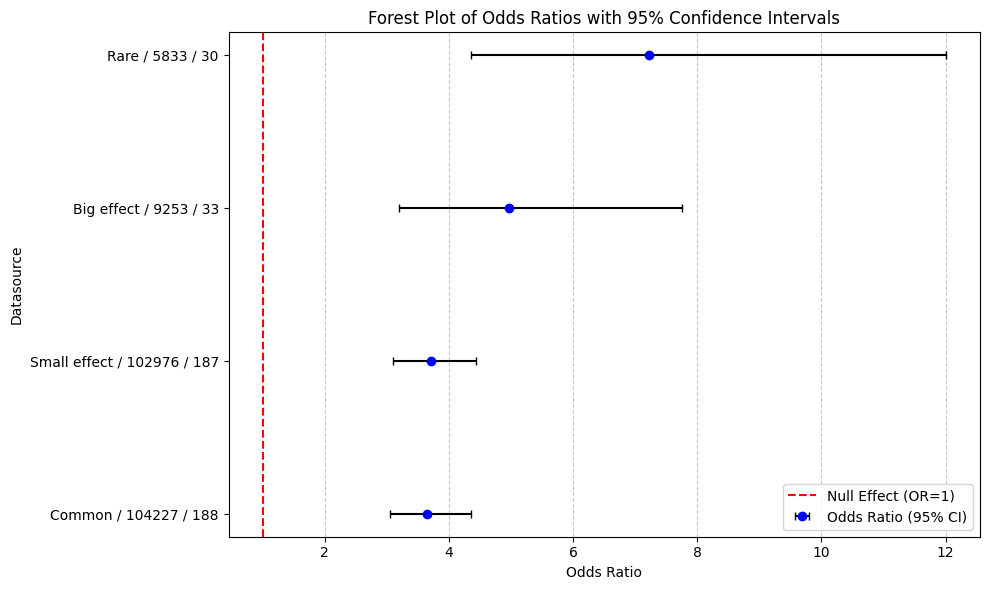

In [28]:
import matplotlib.pyplot as plt

# Assuming `combined_enrich` is your pandas DataFrame
# Sort the DataFrame by odds_ratio for better visualization
combined_enrich_4=combined_enrich[combined_enrich["clinicalPhase"]=="4+"]
combined_enrich_4 = combined_enrich_4.sort_values(by="odds_ratio", ascending=True)

# Extract data for the plot
datasources = combined_enrich_4.apply(
    lambda row: f"{row['datasource']} / {row['total_indirect_assoc']} / {row['yes_evid-high_clinphase']}", axis=1
)
odds_ratios = combined_enrich_4["odds_ratio"]
ci_low = combined_enrich_4["ci_low"]
ci_high = combined_enrich_4["ci_high"]

# Create the forest plot
plt.figure(figsize=(10, 6))
plt.errorbar(odds_ratios, datasources, xerr=[odds_ratios - ci_low, ci_high - odds_ratios], fmt='o', color='blue', ecolor='black', capsize=3, label="Odds Ratio (95% CI)")

# Add labels and title
plt.axvline(x=1, color='red', linestyle='--', label="Null Effect (OR=1)")
plt.xlabel("Odds Ratio")
plt.ylabel("Datasource")
plt.title("Forest Plot of Odds Ratios with 95% Confidence Intervals")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

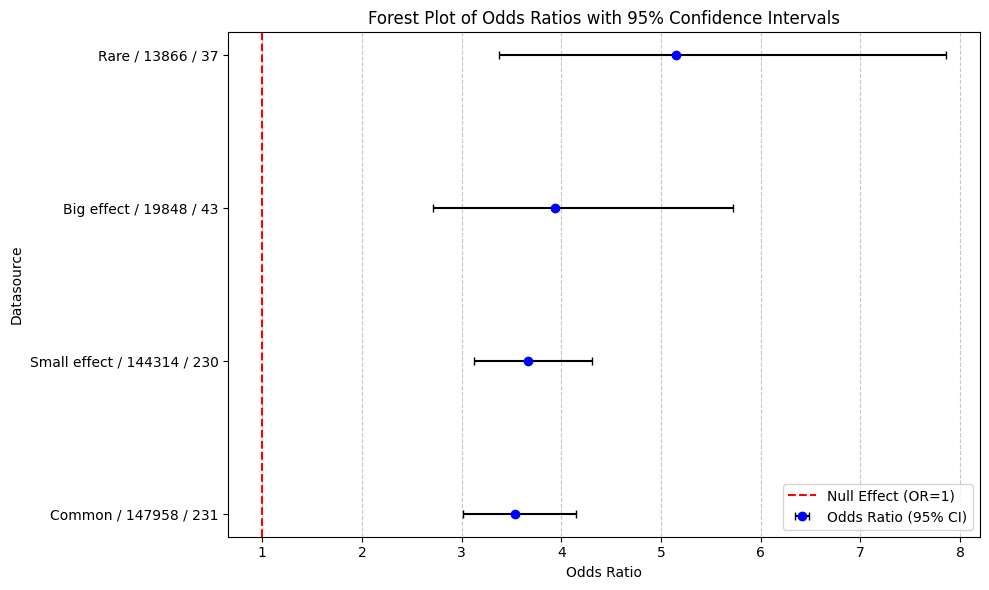

In [109]:
import matplotlib.pyplot as plt

# Assuming `combined_enrich` is your pandas DataFrame
# Sort the DataFrame by odds_ratio for better visualization
combined_enrich_4=combined_enrich[combined_enrich["clinicalPhase"]=="4+"]
combined_enrich_4 = combined_enrich_4.sort_values(by="odds_ratio", ascending=True)

# Extract data for the plot
datasources = combined_enrich_4.apply(
    lambda row: f"{row['datasource']} / {row['total_indirect_assoc']} / {row['yes_evid-high_clinphase']}", axis=1
)
odds_ratios = combined_enrich_4["odds_ratio"]
ci_low = combined_enrich_4["ci_low"]
ci_high = combined_enrich_4["ci_high"]

# Create the forest plot
plt.figure(figsize=(10, 6))
plt.errorbar(odds_ratios, datasources, xerr=[odds_ratios - ci_low, ci_high - odds_ratios], fmt='o', color='blue', ecolor='black', capsize=3, label="Odds Ratio (95% CI)")

# Add labels and title
plt.axvline(x=1, color='red', linestyle='--', label="Null Effect (OR=1)")
plt.xlabel("Odds Ratio")
plt.ylabel("Datasource")
plt.title("Forest Plot of Odds Ratios with 95% Confidence Intervals")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Removing VEP

In [22]:
fm=session.spark.read.parquet(path_to_release_folder+"intermediate/l2g_feature_matrix/")
fm=fm.filter((f.col("isProteinCoding")==1)&(f.col("vepMaximum")>=0.66)).select("studyLocusId","geneId").distinct().cache()
fm.count()

100404

In [26]:
# Rare
studyLoci_to_select=df_filtered.filter(f.col("majorPopulationMAF")<0.01).select("studyLocusId").distinct()
evidence_l2g = l2g.join(studyLoci_to_select, on="studyLocusId", how="inner")
evidence_l2g = evidence_l2g.join(fm,on=["studyLocusId", "geneId"],how="left_anti").cache()
evidence_l2g.count()

3591

In [27]:
coln="Rare_no_VEP"
evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=evidence_l2g,
    score_column="score",
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.5
)
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.5,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = coln
all_enrich.append(enrich)

In [28]:
# Common
studyLoci_to_select=df_filtered.filter(f.col("majorPopulationMAF")>=0.01).select("studyLocusId").distinct()
evidence_l2g = l2g.join(studyLoci_to_select, on="studyLocusId", how="inner")
evidence_l2g = evidence_l2g.join(fm,on=["studyLocusId", "geneId"],how="left_anti").cache()
evidence_l2g.count()

76880

In [29]:
coln="Common_no_VEP"
evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=evidence_l2g,
    score_column="score",
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.5
)
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.5,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = coln
all_enrich.append(enrich)

In [30]:
# Big effect
studyLoci_to_select=df_filtered.filter((f.col("rescaledStatistics.estimatedBeta")>0.5)|(f.col("rescaledStatistics.estimatedBeta")<-0.5)).select("studyLocusId").distinct()
evidence_l2g = l2g.join(studyLoci_to_select, on="studyLocusId", how="inner")
evidence_l2g = evidence_l2g.join(fm,on=["studyLocusId", "geneId"],how="left_anti").cache()
evidence_l2g.count()

2606

In [31]:
coln="Big_effect_no_VEP"
evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=evidence_l2g,
    score_column="score",
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.5
)
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.5,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = coln
all_enrich.append(enrich)

In [32]:
# Small effect
studyLoci_to_select=df_filtered.filter((f.col("rescaledStatistics.estimatedBeta")<=0.5)&(f.col("rescaledStatistics.estimatedBeta")>=-0.5)).select("studyLocusId").distinct()
evidence_l2g = l2g.join(studyLoci_to_select, on="studyLocusId", how="inner")
evidence_l2g = evidence_l2g.join(fm,on=["studyLocusId", "geneId"],how="left_anti").cache()
evidence_l2g.count()

77865

In [33]:
coln="Small_effect_no_VEP"
evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=evidence_l2g,
    score_column="score",
    datasource_id=coln,
    study_locus=sl,
    study_index=si,
    min_score=0.5
)
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.5,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = coln
all_enrich.append(enrich)

In [34]:
combined_enrich = pd.concat(all_enrich, ignore_index=True)

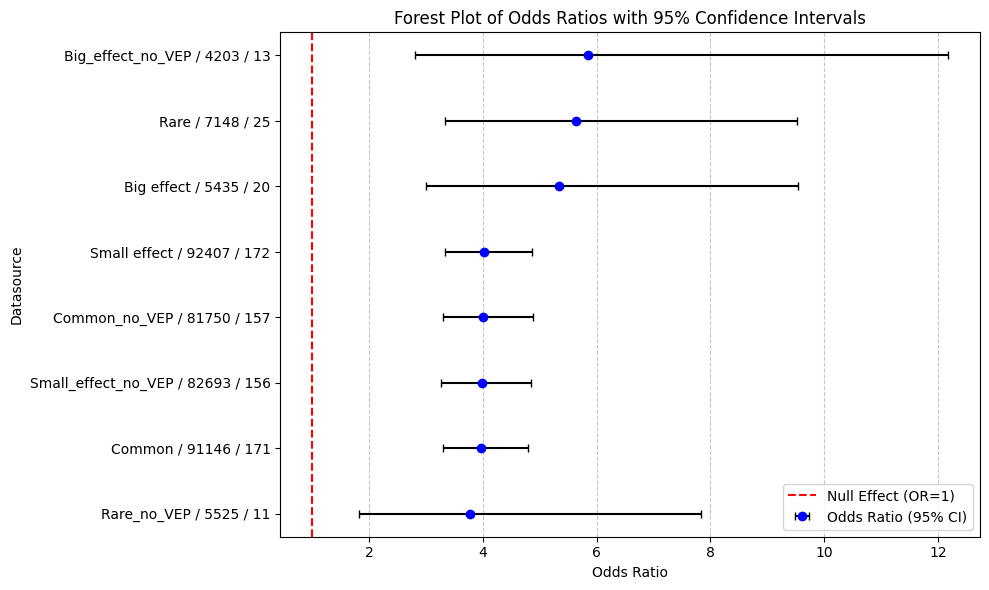

In [35]:
import matplotlib.pyplot as plt

# Assuming `combined_enrich` is your pandas DataFrame
# Sort the DataFrame by odds_ratio for better visualization
combined_enrich_4=combined_enrich[combined_enrich["clinicalPhase"]=="4+"]
combined_enrich_4 = combined_enrich_4.sort_values(by="odds_ratio", ascending=True)

# Extract data for the plot
datasources = combined_enrich_4.apply(
    lambda row: f"{row['datasource']} / {row['total_indirect_assoc']} / {row['yes_evid-high_clinphase']}", axis=1
)
odds_ratios = combined_enrich_4["odds_ratio"]
ci_low = combined_enrich_4["ci_low"]
ci_high = combined_enrich_4["ci_high"]

# Create the forest plot
plt.figure(figsize=(10, 6))
plt.errorbar(odds_ratios, datasources, xerr=[odds_ratios - ci_low, ci_high - odds_ratios], fmt='o', color='blue', ecolor='black', capsize=3, label="Odds Ratio (95% CI)")

# Add labels and title
plt.axvline(x=1, color='red', linestyle='--', label="Null Effect (OR=1)")
plt.xlabel("Odds Ratio")
plt.ylabel("Datasource")
plt.title("Forest Plot of Odds Ratios with 95% Confidence Intervals")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [36]:
folder_to_save="chembl_enrichment/"
combined_enrich.to_csv(folder_to_save+"big_small_beta_rare_common.csv", index=False)

In [ ]:
combined_enrich[combined_enrich["clinicalPhase"]=="4+"]

,clinicalPhase,odds_ratio,p_value,ci_low,ci_high,no_evid-low_clinphase,no_evid-high_clinphase,yes_evid-low_clinphase,yes_evid-high_clinphase,total_indirect_assoc,datasource
2,4+,5.642246,2.623803e-09,3.340717,9.529375,32781,4539,32,25,7148,Rare
5,4+,3.977630,2.136033e-39,3.294218,4.802820,32495,4393,318,171,91146,Common
8,4+,5.344614,1.865452e-07,2.995220,9.536829,32786,4544,27,20,5435,Big effect
11,4+,4.027377,3.912708e-40,3.335896,4.862192,32497,4392,316,172,92407,Small effect
14,4+,3.772625,9.794076e-04,1.817775,7.829738,32792,4553,21,11,5525,Rare_no_VEP
17,4+,4.009246,1.167067e-36,3.292837,4.881521,32524,4407,289,157,81750,Common_no_VEP
20,4+,5.855320,1.328098e-05,2.814662,12.180781,32797,4551,16,13,4203,Big_effect_no_VEP
23,4+,3.982806,3.449508e-36,3.269822,4.851256,32524,4408,289,156,82693,Small_effect_no_VEP


25/04/25 05:35:13 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1042140 ms exceeds timeout 120000 ms
25/04/25 05:35:13 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/25 05:35:17 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$